In [ ]:
#importing the standard Python modules
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
def Uint8ToCell(arr):
  #this function convertrs an array from unit8, 0-255, oBlack, 255White to -1White, 1Black
  arr=(-1)*((arr.astype(np.float))/128.0-1.0)
  return arr

In [ ]:
#download mnist dataset
#read data and display data

mnist = input_data.read_data_sets("MNIST_data/")
train_images=2.0*(mnist.train.images)-1.0
train_labels = mnist.train.labels
#select nines from the data
TrainNines=train_images[train_labels==9]


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
def CellNonlin(x):
    #leaky implementationn of CNN nonline to provide gradients below -1 and above 1
    alpha=0.01
    y= tf.minimum(x,1+alpha*(x-1) )
    y= tf.maximum(y,-1+alpha*(y+1))
    #y=tf.nn.relu(x)
    return y
  
def CellNN(Input, InputDepth,OutputDepth,UseBatchNorm=True,IterNum=10):
    A = tf.get_variable('Atemplate',[3,3,OutputDepth,OutputDepth])
    B = tf.get_variable('Btemplate',[3,3,InputDepth,OutputDepth])
    Z = tf.get_variable('Bias',[OutputDepth])
    Scale = tf.get_variable('Rescale',[1,1,InputDepth,OutputDepth])
    h=tf.get_variable('TimeStep',[OutputDepth],  initializer=tf.constant_initializer(0.01))
    #h=0.1
    InputCoupling = tf.nn.conv2d(Input,B,strides=[1,1,1,1],padding='SAME') #VALID, SAME
    InputCoupling = InputCoupling+Z  
    #rescale
    x=tf.nn.conv2d(Input,Scale,strides=[1,1,1,1],padding='SAME') 
    for it in range(IterNum):
        y=CellNonlin(x)
        OutputCoupling = tf.nn.conv2d(y,A,strides=[1,1,1,1],padding='SAME') #VALID, SAME
        x=x+h*(-1*(x)+ OutputCoupling + InputCoupling)
    #x=InputCoupling
    Out=CellNonlin(x) 
    if UseBatchNorm:
      Out = tf.layers.batch_normalization(Out, training=True)
    return Out       
            
def DoubleSize(x): 
    #resize the image
    sh=x.get_shape()
    x=tf.image.resize(x,[int(sh[1])*2,int(sh[2])*2]) 
    return x
  
def generator(CurrentInput, img_size=28):
    with tf.variable_scope("generator"):

      
      W = tf.get_variable('W1',[100,img_size*img_size])
      b = tf.get_variable('b1',[img_size*img_size])
      CurrentInput = tf.matmul(CurrentInput, W)+b
      CurrentInput = CellNonlin(CurrentInput) 
      CurrentInput = tf.layers.batch_normalization(CurrentInput, training=True)
      
     
      W = tf.get_variable('W2',[img_size*img_size, int(img_size/4*img_size/4* 1)])
      b = tf.get_variable('b2',[int(img_size/4*img_size/4* 1)])
      CurrentInput = tf.matmul(CurrentInput, W)+b
      CurrentInput = CellNonlin(CurrentInput) 
      CurrentInput = tf.layers.batch_normalization(CurrentInput, training=True)
      
      CurrentInput = tf.reshape(CurrentInput, [-1, int(img_size/4), int(img_size/4), 1])
      with tf.variable_scope("Layer0"):
         CurrentInput=CellNN(CurrentInput, 1,64) 

      CurrentInput=DoubleSize(CurrentInput)
      with tf.variable_scope("Layer1"):
         CurrentInput=CellNN(CurrentInput, 64,128) 
          
      CurrentInput=DoubleSize(CurrentInput)
      with tf.variable_scope("Layer2"):
         CurrentInput=CellNN(CurrentInput, 128,1,UseBatchNorm=False)  

    return CurrentInput


In [ ]:
def discriminator(CurrentInput, reuse=False, img_size=28):
    with tf.variable_scope("discriminator"):
      if reuse:
            tf.get_variable_scope().reuse_variables()
      with tf.variable_scope("Layer0"):
         CurrentInput=CellNN(CurrentInput, 1,64)
      
      with tf.variable_scope("Layer1"):
         CurrentInput=CellNN(CurrentInput, 64,64)
      
      with tf.variable_scope("Layer2"):
         CurrentInput=CellNN(CurrentInput, 64,64)
      
      with tf.variable_scope("Layer3"):
         CurrentInput=CellNN(CurrentInput, 64,1,UseBatchNorm=False)
      CurrentInput = tf.reshape(CurrentInput, [-1, img_size*img_size*1])
      W = tf.get_variable('W',[img_size*img_size,1])
      B = tf.get_variable("B", [1])
    
      CurrentInput = tf.matmul(CurrentInput, W)+B
    return CurrentInput

In [ ]:
tf.reset_default_graph()
Size=[28,28]

ph_real = tf.placeholder("float", shape=[None, Size[0], Size[1], 1])
ph_noise = tf.placeholder("float", shape=[None, 100])
 

NetOut=generator(ph_noise)

FakeResponse = discriminator(NetOut)
RealResponse = discriminator(ph_real, reuse=True)

In [ ]:
#GLoss = tf.reduce_mean( tf.square(tf.ones_like(FakeResponse)-FakeResponse) )
#DLossReal = tf.reduce_mean( tf.square(tf.ones_like(RealResponse)-RealResponse) )
#DLossFake = tf.reduce_mean( tf.square((-1.0*tf.ones_like(FakeResponse))-FakeResponse) )
#GLoss = tf.reduce_mean( tf.abs(tf.ones_like(FakeResponse)-FakeResponse) )
#DLossReal = tf.reduce_mean( tf.abs(tf.ones_like(RealResponse)-RealResponse) )
#DLossFake = tf.reduce_mean( tf.abs((-1.0*tf.ones_like(FakeResponse))-FakeResponse) )
GLoss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=FakeResponse, labels=tf.ones_like(FakeResponse)))
DLossReal = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=RealResponse, labels=tf.ones_like(RealResponse)))
DLossFake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=FakeResponse, labels=tf.zeros_like(FakeResponse)))

DLoss = DLossReal + DLossFake


tvars = tf.trainable_variables()

DiscVars = [var for var in tvars if 'discriminator' in var.name]
GenVars = [var for var in tvars if 'generator' in var.name]

Dopt = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5).minimize(DLoss, var_list=DiscVars)
Gopt = tf.train.AdamOptimizer(learning_rate=5e-4, beta1=0.5).minimize(GLoss, var_list=GenVars)
#Dopt = tf.train.AdamOptimizer().minimize(DLoss, var_list=DiscVars)
#Gopt = tf.train.AdamOptimizer().minimize(GLoss, var_list=GenVars)
#Dopt = tf.train.GradientDescentOptimizer(1e-3).minimize(DLoss, var_list=DiscVars)
#Gopt = tf.train.GradientDescentOptimizer(1e-2).minimize(GLoss, var_list=GenVars)
Init = tf.global_variables_initializer()  

0.9029835 0.98569334


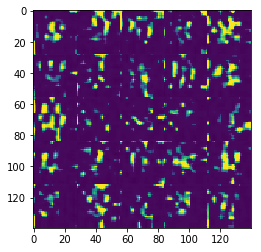

1.1885266 0.84834


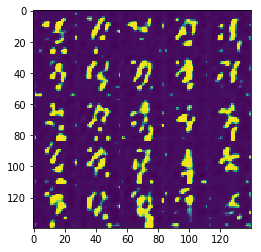

1.0766141 1.1423559


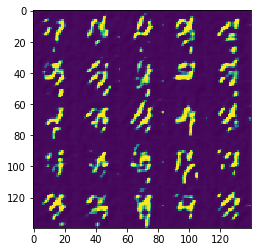

0.8925555 0.9833326


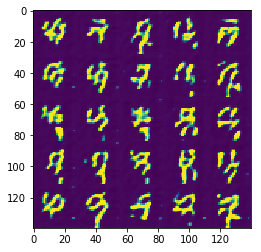

1.1555606 0.94788575


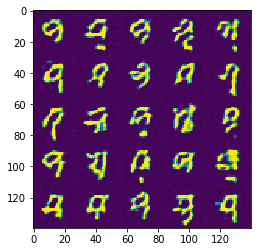

1.4270692 0.6220639


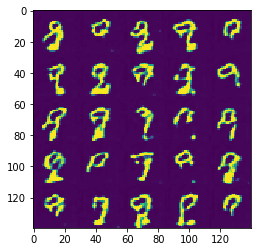

1.2124629 0.6887077


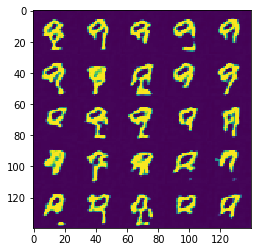

1.3952105 1.0835459


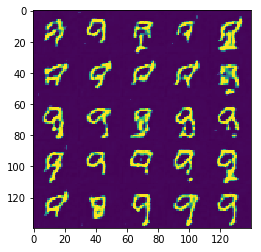

1.10921 1.541383


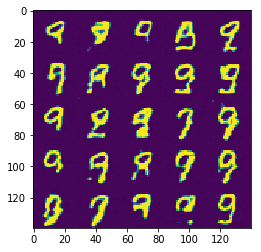

In [ ]:
BatchSize=32
# Initializing the variables
Init = tf.global_variables_initializer()
RealImgs=np.zeros((BatchSize,Size[0], Size[1], 1))

with tf.Session() as Sess:
	Sess.run(Init)	 
	Step = 1
	# Keep training until reach max iterations - other stopping criterion could be added
	while Step < 1000:
		
		##create train batch - select random elements for training
		#SelectedSamples= random.sample( range(train_images.shape[0]), int(BatchSize))
		#RealImgs=np.reshape(train_images[SelectedSamples,:],[BatchSize,Size[0], Size[1], 1])
		TrainIndices = random.sample(range(TrainNines.shape[0]), BatchSize)
		RealImgs=np.reshape(TrainNines[TrainIndices,:],[BatchSize,Size[0], Size[1], 1])

		#Noise=np.random.uniform(-1,1,[BatchSize,Size[0], Size[1], 1])
		Noise=np.random.uniform(-1,1,[BatchSize,100])
	
		#train the discriminator 
		_,DL = Sess.run([Dopt, DLoss], feed_dict={ph_real: RealImgs, ph_noise: Noise})
    
    
		#train the generator
		#Noise=np.random.uniform(-1,1,[BatchSize,Size[0], Size[1], 1])
		Noise=np.random.uniform(-1,1,[BatchSize,100])
		_,GL = Sess.run([Gopt, GLoss], feed_dict={ ph_noise: Noise})
		#Noise=np.random.uniform(-1,1,[BatchSize,100])
		#_,GL = Sess.run([Gopt, GLoss], feed_dict={ ph_noise: Noise})



		if (Step%100==0):
		    print(str(DL)+" "+str(GL))

    
		    #Noise=np.random.uniform(-1,1,[BatchSize,Size[0], Size[1], 1])
		    Noise=np.random.uniform(-1,1,[BatchSize,100])
	      #display 25 independent test samples
		    Imgs = Sess.run(NetOut, feed_dict={ ph_noise: Noise})
		    NumImgs=5
		    ImgMatrix=np.zeros((NumImgs*Size[0],NumImgs*Size[1]))
		    for i in range(NumImgs):
		      for j in range(NumImgs):
		        ImgMatrix[i*Size[0]:(i+1)*Size[0] ,j*Size[1]:(j+1)*Size[1] ]=(Imgs[NumImgs*i+j,:,:,0]+1)*128
		    plt.imshow(ImgMatrix)
		    plt.show()
		Step+=1